# Minimum variance portfolio on selected Danish stocks

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from port_opt import get_portf_vol, get_optimal_portfolio, get_efficient_frontier, neg_portf_rtn

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [5.5, 3]
plt.rcParams['figure.dpi'] = 200

np.random.seed(0)

## Load the preprocessed data

To see how the input has been processed and why go to see the [Input data preparation notebook](./input_data_preparation.ipynb)

In [ ]:
%run preprocessing.py -n DK -i stock

In [3]:
# Load numpy arrays .npy from data folder
mu = np.load('..\data\DK\preprocessed_data\stocks\m.npy')
cov = np.load('..\data\DK\preprocessed_data\stocks\S.npy')
close_df = pd.read_csv('..\data\DK\preprocessed_data\danish_closed_stocks.csv', index_col=0)

In [14]:
# Constants
danish_2y_yield = 0.03463
stocks_names = close_df.columns.tolist()

## Portfolio optimization

In [16]:
n_days = 260
n_portfolios = 100_000
n_assets = len(mu)

In [17]:
weights = np.random.random(size=(n_portfolios, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [18]:
portf_rtns = np.dot(weights, mu)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = (portf_rtns - danish_2y_yield) / portf_vol

In [19]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [20]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

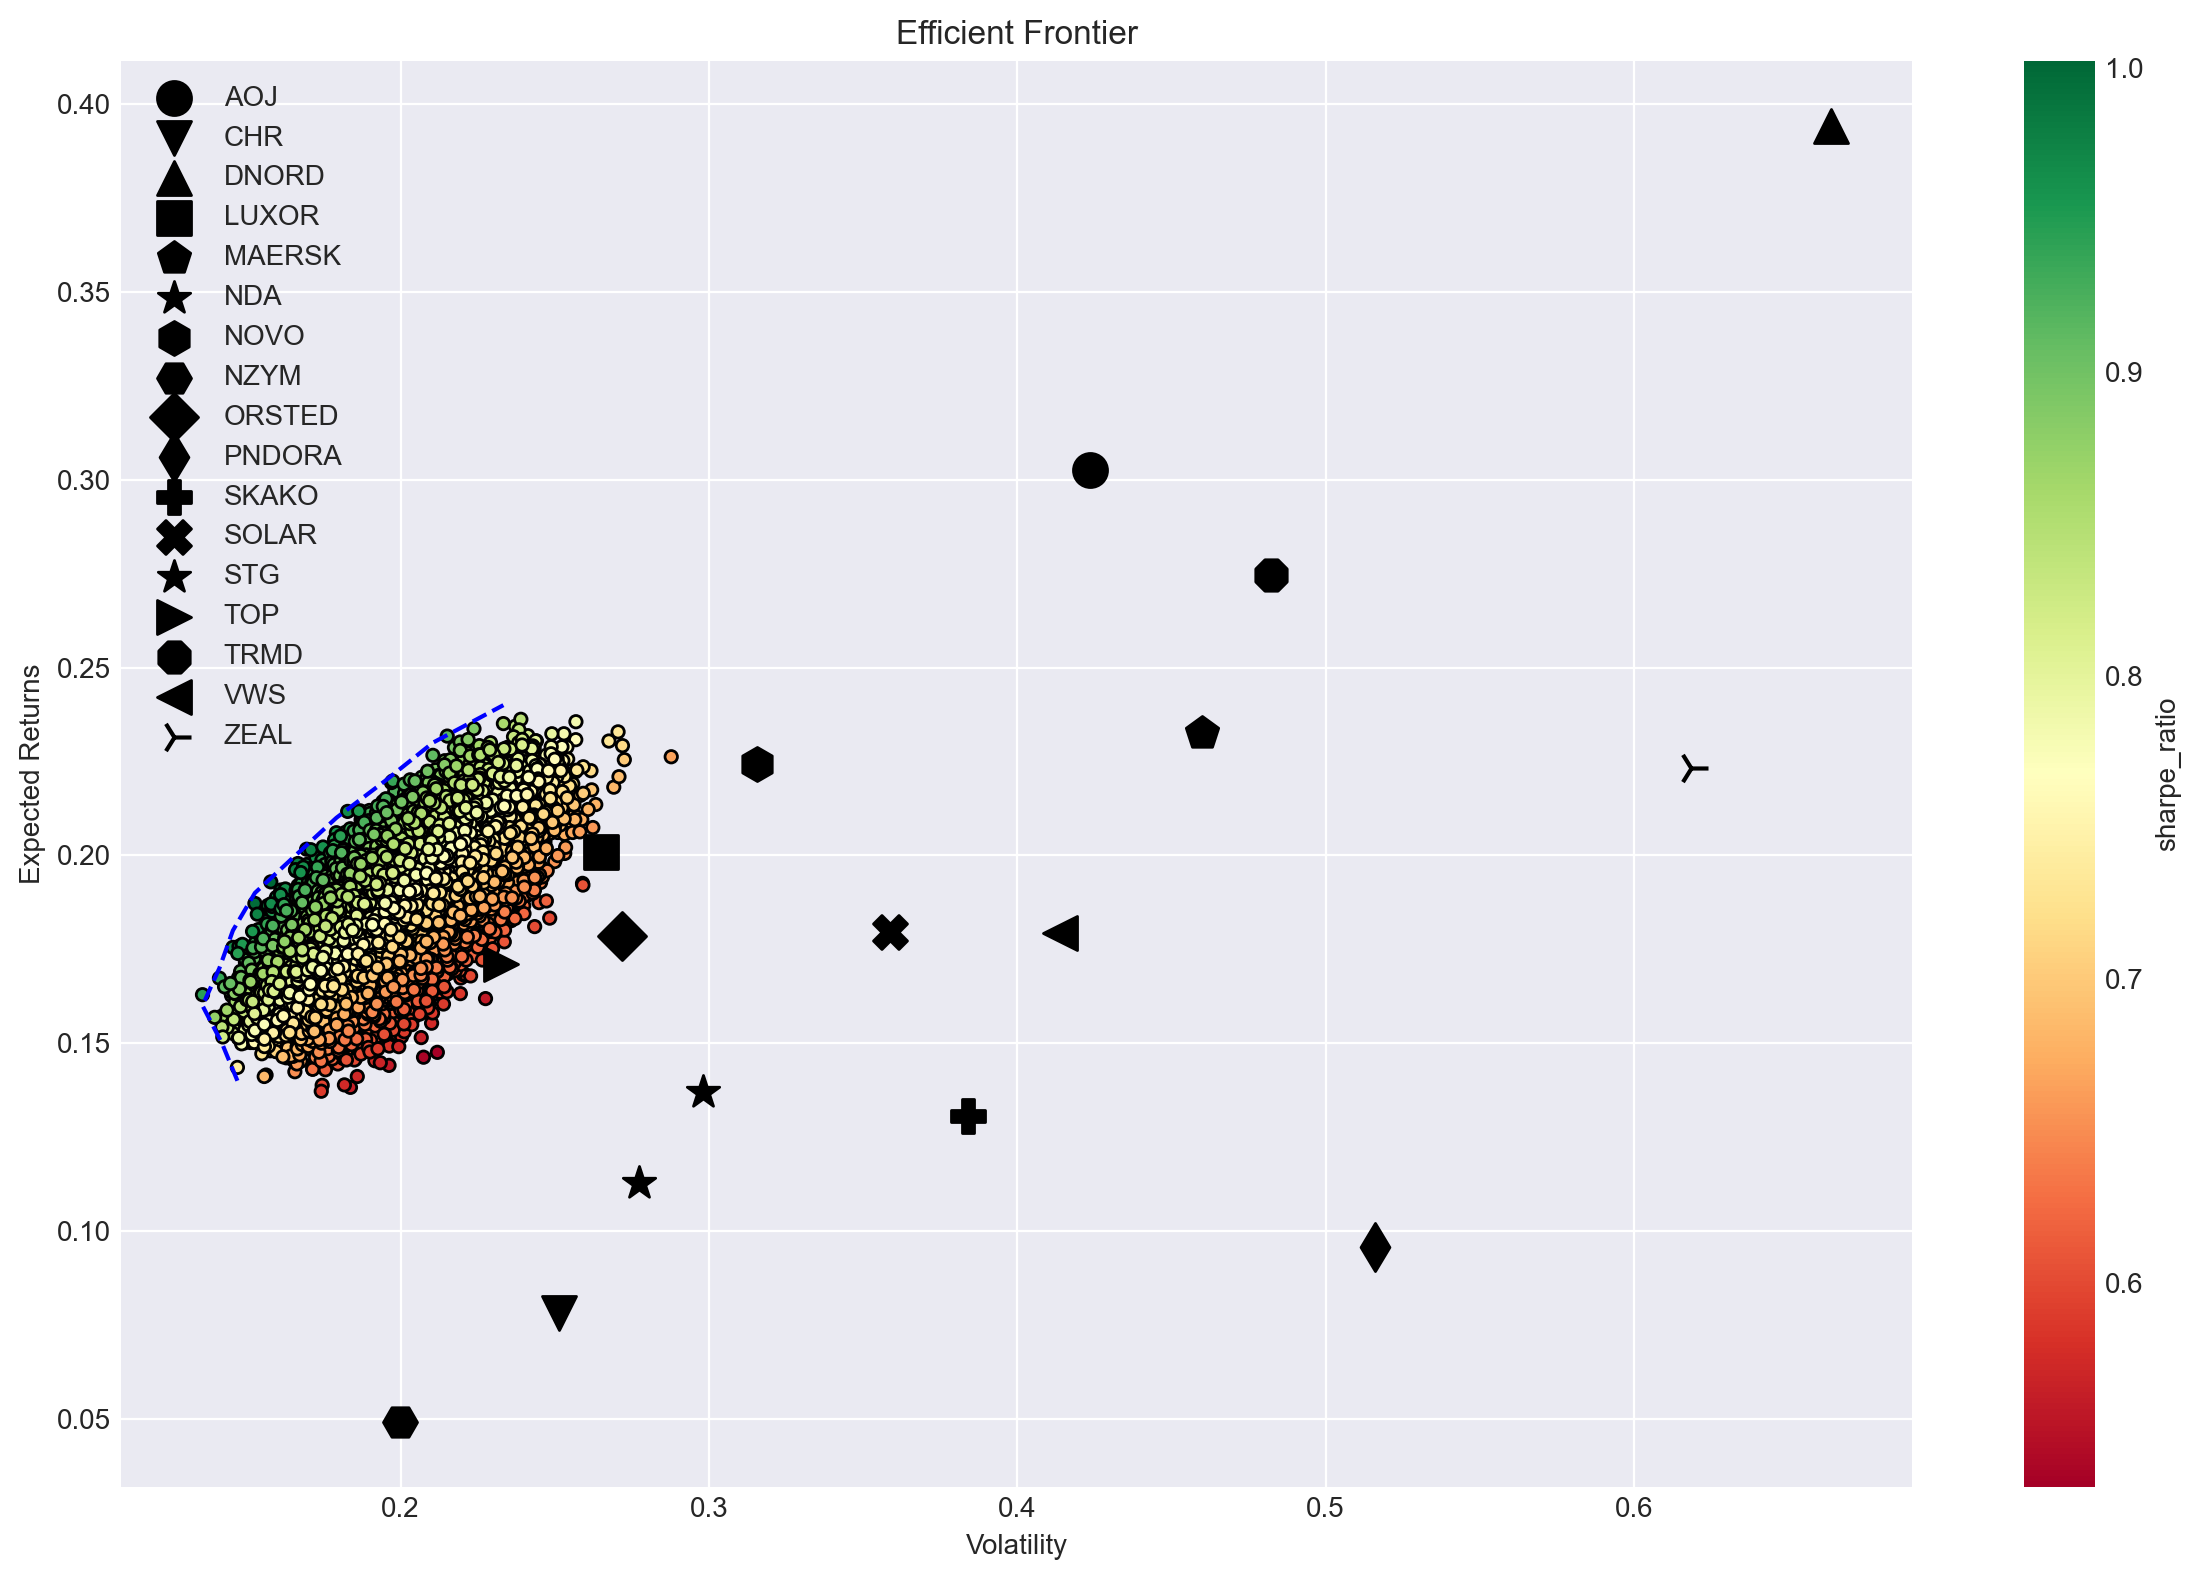

In [21]:
MARKS = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '*', 
         '>', '8', '<', '4']

fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov[asset_index, asset_index]), 
                y=mu[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### Min variance portfolio

The term “Minimum Variance Portfolio” refers to the portfolio with the lowest variance. This portfolio can be obtained by solving the following quadratic programming model:

$$
\begin{align}
\min_{\mathbf{w}} \quad & \mathbf{w}^T \mathbf{\Sigma} \mathbf{w}  &\\
\text{s.t.: } \quad & \mathbf{w}^t \boldsymbol \mu &= \mathbf{r}^* \\
& \sum_{i=1}^N w_i &= 1
\end{align}
$$

In [22]:
rtns_range = np.linspace(-0.22, 0.50, 200)

In [23]:
efficient_portfolios = get_efficient_frontier(mu, 
                                              cov, 
                                              rtns_range)

In [24]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [25]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': ((min_vol_portf_rtn - danish_2y_yield) / 
                                  min_vol_portf_vol)}

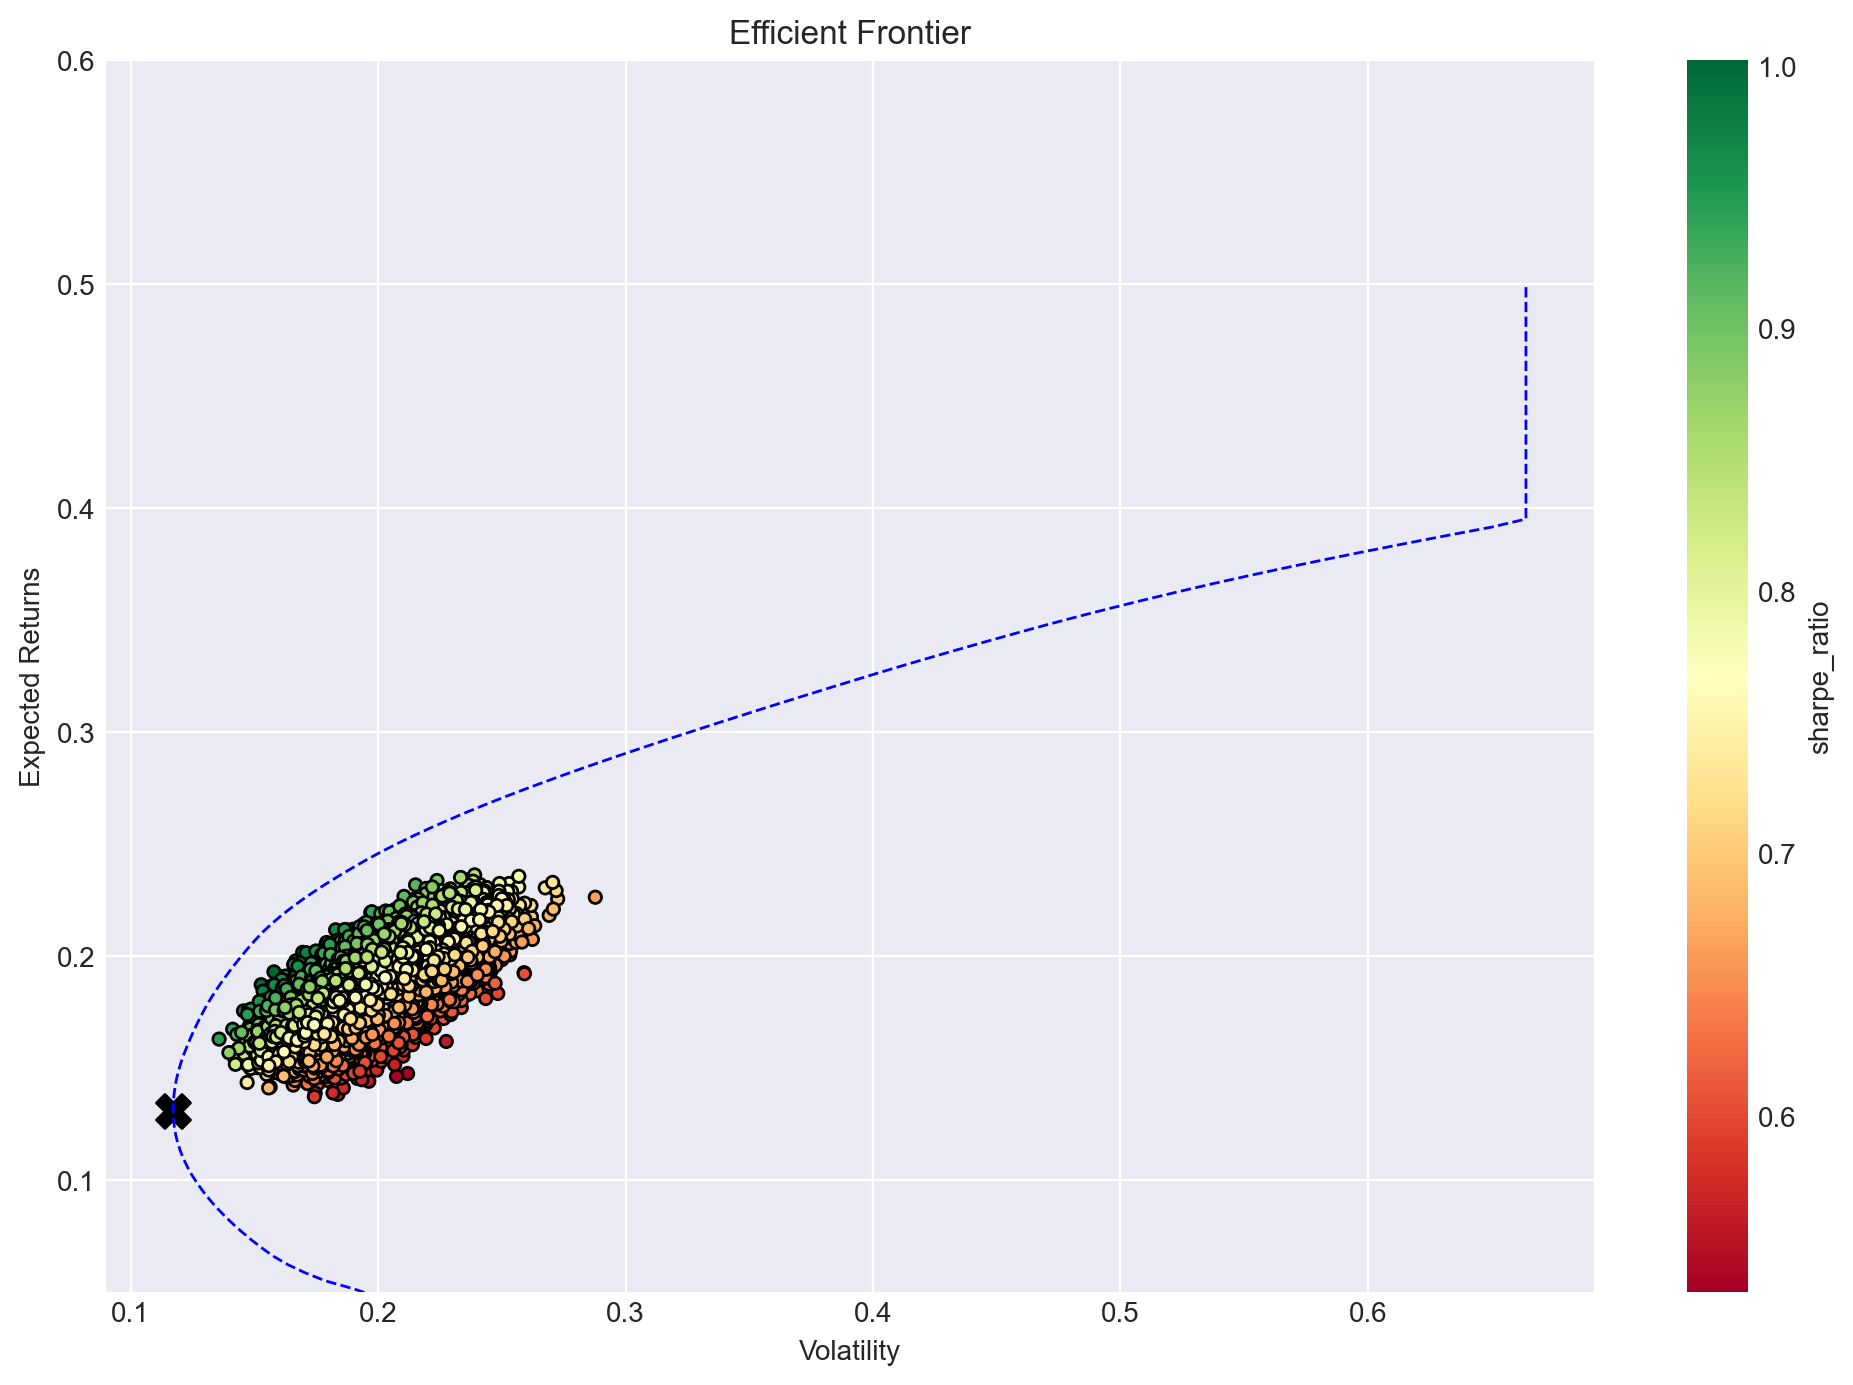

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=1)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.scatter(x=min_vol_portf_vol, 
                y=min_vol_portf_rtn, 
                marker='X', 
                s=150, 
                color='black',
                label='MVP')

plt.ylim(0.05,0.6)
plt.show()

In [27]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(stocks_names, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 13.10% Volatility: 11.72% Sharpe Ratio: 82.17% 
Weights
AOJ: 0.00% CHR: 16.51% DNORD: 0.00% LUXOR: 19.18% MAERSK: 0.00% NDA: 4.54% NOVO: 1.56% NZYM: 20.19% ORSTED: 7.55% PNDORA: 0.00% SKAKO: 6.52% SOLAR: 0.00% STG: 7.56% TOP: 13.84% TRMD: 0.00% VWS: 0.00% ZEAL: 2.56% 

### Alternative formulation - Maximize the returns


$$
\begin{align}
\max_{\mathbf{w}} \quad & \mathbf{w}^T \mathbf{r}  &\\
\text{s.t.: } \quad & \mathbf{w}^T \mathbf{\Sigma} \mathbf{w}  &\le \gamma^2 \\
& \sum_{i=1}^N w_i &= 1 \\
& \mathbf{w} \ge 0
\end{align}
$$

which is equivalent to the following problem:

$$
\begin{align}
\min_{\mathbf{w}} \quad & -\mathbf{w}^T \mathbf{r}  &\\
\text{s.t.: } \quad & \mathbf{w}^T \mathbf{\Sigma} \mathbf{w}  &\le \gamma^2 \\
& \sum_{i=1}^N w_i &= 1 \\
& \mathbf{w} \ge 0
\end{align}
$$


In [29]:
gamma = 0.54
get_max_ret_const = lambda gamma: ({
    'type': 'ineq',
    'fun': lambda x: -get_portf_vol(x, 0.0, cov) + gamma ** 2},
    {'type': 'eq',
     'fun': lambda x: np.sum(x) - 1})
constraints = get_max_ret_const(gamma)
res = get_optimal_portfolio(
    f_obj=neg_portf_rtn,
    args=(mu,),
    constraints=constraints,
    bounds=tuple((0,1) for _ in range(n_assets))
)

In [30]:
gammas = np.linspace(0.3162, 0.7071, 50)

In [31]:
ret_results = []
for gamma in gammas:
    constraints = get_max_ret_const(gamma)
    res = get_optimal_portfolio(
        f_obj=neg_portf_rtn,
        args=(mu,),
        constraints=constraints,
        bounds=tuple((0,1) for _ in range(n_assets))
    )
    ret_results.append({
        'vol': np.power(gamma, 2),
        'ret': -res.fun,
        'x': res.x
    })

In [32]:
max_ret_portfolio = sorted(ret_results, key=lambda x: x['ret'], reverse=True)[0]

In [40]:
print('Maximum Return portfolio ----')
print('Performance')

ret_max_portfolio = max_ret_portfolio['ret'] * 100
vol_max_portfolio = max_ret_portfolio['vol'] * 100

print(f'Return: {ret_max_portfolio:.2f}%')
print(f'Volatility: {vol_max_portfolio:.2f}%')
print(f'Sharpe Ratio: {((ret_max_portfolio - danish_2y_yield) / vol_max_portfolio) * 100:.2f}%')


print('\nWeights')
for x, y in zip(stocks_names, max_ret_portfolio['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Return portfolio ----
Performance
Return: 35.64%
Volatility: 50.00%
Sharpe Ratio: 71.21%

Weights
AOJ: 36.27% CHR: 0.00% DNORD: 60.98% LUXOR: 0.00% MAERSK: 0.00% NDA: 0.00% NOVO: 0.00% NZYM: 0.00% ORSTED: 0.00% PNDORA: 0.00% SKAKO: 0.00% SOLAR: 0.00% STG: 0.00% TOP: 0.00% TRMD: 0.00% VWS: 0.00% ZEAL: 2.75% 

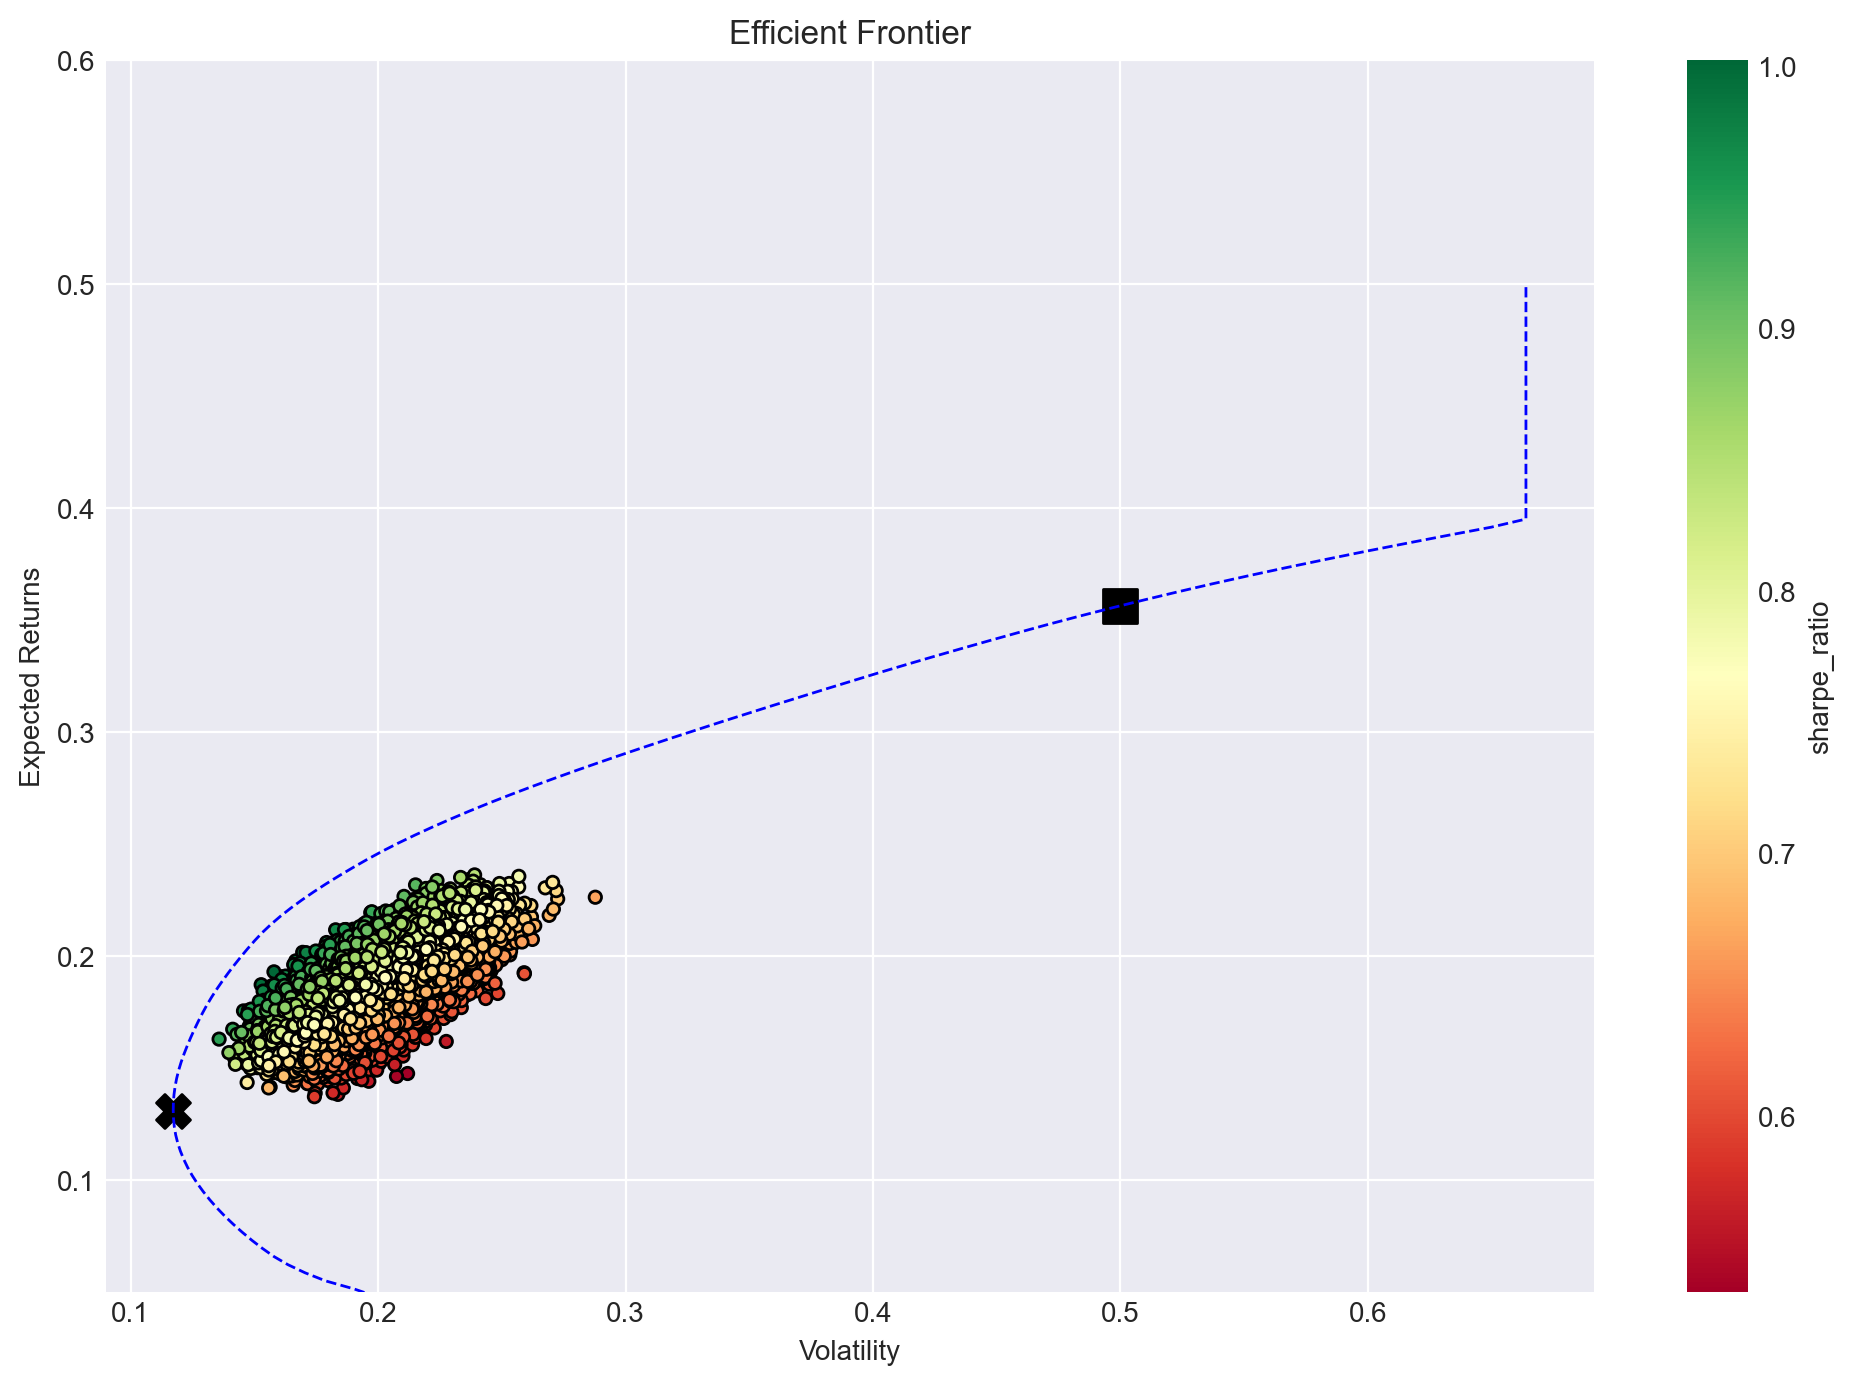

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=1)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.scatter(x=min_vol_portf_vol, 
                y=min_vol_portf_rtn, 
                marker='X', 
                s=150, 
                color='black',
                label='MVP')
ax.scatter(x=max_ret_portfolio['vol'],
              y=max_ret_portfolio['ret'],
                marker='s',
                s=150,
                color='black',
                label='Max Return Portfolio')

plt.ylim(0.05,0.6)
plt.show()

### Include transaction costs

$$
\begin{align*}
\text{minimize} \quad & \mathbf{w}^T  \mathbf{\Sigma}\mathbf{w} \\
\text{subject to} \quad & \mathbf{w}^T \mathbf{\mu} \geq \mathbf{r} \\
& \mathbf{1}^T \mathbf{w}  \leq 1 \\
& \sum_{i} |w_i - w_{0, i}| \cdot c \leq T - C * 0.0044 \\
& \mathbf{x} \geq \mathbf{0}
\end{align*}
$$

where $T$ is the maximum amount that I'm willing to spend on trasaction costs, and $C$ is the initial capital.